# create_figures_relationship_type

__Author:__ Emma Crenshaw \
__Date:__  10/1/2023 

__Purpose:__ Takes the infection tracker output and creates figures showing results by relationship type. To recreate the published figures, this takes the output from simulation scenario "70-2-0.5-012-30-2"

__Inputs__:
* specify the simulation inputs
* specify the date

In [1]:
import pandas as pd
import numpy as np
import os
import zipfile as zf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools

import seaborn as sns
import matplotlib.gridspec as gs

#%matplotlib notebook
%matplotlib inline

# Set all font sizes
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
sim_name = 'tracker_'
date = '2024-10-10'

num_sims = 100
steps = 250

intervention_start = [70]
intervention_start_name = '70'

behavior_change = 2
isolation = [0,1,2]
isolation_name = '012'

behavior_change_perc = 0.5
vax_scenario = 2
vax_delay_name = '30'
vax_delay = [30]

sim_string = str(intervention_start_name) + '-' + str(behavior_change) + '-' + str(behavior_change_perc) + \
      '-' + str(isolation_name) + '-' + str(vax_delay_name) + '-' + str(vax_scenario)
    
location = 'output/' + sim_string + '/'

In [3]:
def calc_rstats(sim_string, want, N = 10000, num_sims = 100, steps = 250, intervention_start = [70], behavior_change = 2, isolation = [0,1,2], vax_delay = [30]):
    totnum = len(vax_delay)*len(intervention_start)*len(isolation)
    df = np.zeros((totnum,steps+3))

    rstar_list = list(range(0,258,7))
    print(rstar_list)


    # R_star, total
    r_tot = np.zeros((num_sims, len(rstar_list)))
    # R_star, one-time partnerships
    r_ot = np.zeros((num_sims, len(rstar_list)))
    # R_star, casual partnerships
    r_c = np.zeros((num_sims, len(rstar_list)))
    # R_star, main partnerships
    r_m = np.zeros((num_sims, len(rstar_list)))
    # Number of infections attributable to spread via one-time partnerships
    ot_infections = np.zeros((num_sims, steps))
    # Number of infections attributable to spread via one-time partnerships
    c_infections = np.zeros((num_sims, steps))
    # Number of infections attributable to spread via one-time partnerships
    m_infections = np.zeros((num_sims, steps))

    for i in range(0, num_sims):
        index = i + 1
        all_tracker = np.array(pd.read_csv(location + str(sim_name) + sim_string + '_'+ str(index) + '_' + date + '.csv'))

        start = want*N
        stop = start+N
        infection_tracker = all_tracker[start:stop,:]

        initial_infections = np.where(infection_tracker[:,0] == -1)[0].tolist()
        secondary_infections = np.where(np.isin(infection_tracker[:,0],initial_infections))[0].tolist()

        r_tot[i, 0] = len(secondary_infections)/len(initial_infections)
        r_ot[i, 0] = len(np.where(np.isin(infection_tracker[:,0],initial_infections) & (infection_tracker[:,3]==3))[0].tolist())/len(initial_infections)
        r_c[i, 0] = len(np.where(np.isin(infection_tracker[:,0],initial_infections) & (infection_tracker[:,3]==2))[0].tolist())/len(initial_infections)
        r_m[i, 0] = len(np.where(np.isin(infection_tracker[:,0],initial_infections) & (infection_tracker[:,3]==1))[0].tolist())/len(initial_infections)

        #Rstar
        for star in range(1,len(rstar_list)):
            infectious = np.where((infection_tracker[:,1] < rstar_list[star]) & (infection_tracker[:,2] > (rstar_list[star]-7)))[0].tolist()
            infected = np.where(np.isin(infection_tracker[:,0], infectious))[0].tolist()

            if len(infectious) > 0:
                r_tot[i,star] = len(infected)/len(infectious)
                r_ot[i,star] = len(np.where(np.isin(infection_tracker[:,0], infectious) & (infection_tracker[:,3]==3))[0].tolist()) / len(infectious)
                r_c[i,star] = len(np.where(np.isin(infection_tracker[:,0], infectious) & (infection_tracker[:,3]==2))[0].tolist()) / len(infectious)
                r_m[i,star] = len(np.where(np.isin(infection_tracker[:,0], infectious) & (infection_tracker[:,3]==1))[0].tolist()) / len(infectious)
            else: 
                r_tot[i,star] = 0
                r_ot[i,star] = 0
                r_c[i,star] = 0
                r_m[i,star] = 0

            # infections caused by one-time partners
            #print(len(np.where((infection_tracker[:,3]==3) & (infection_tracker[:,1] < rstar_list[star]))[0].tolist()))

        for j in range(0,steps):
            ot_infections[i, j] = len(np.where((infection_tracker[:,3]==3) & (infection_tracker[:,1] < j))[0].tolist())
            c_infections[i, j] = len(np.where((infection_tracker[:,3]==2) & (infection_tracker[:,1] < j))[0].tolist())
            m_infections[i, j] = len(np.where((infection_tracker[:,3]==1) & (infection_tracker[:,1] < j))[0].tolist())

    return(r_tot, r_ot, r_c, r_m, ot_infections, c_infections, m_infections)
        




In [4]:
# Get results under different isolation scenarios (1 = partial compliance, 2 = full compliance)

r_tot, r_ot, r_c, r_m, ot_infections, c_infections, m_infections = calc_rstats(sim_string, 1)
r_tot2, r_ot2, r_c2, r_m2, ot_infections2, c_infections2, m_infections2 = calc_rstats(sim_string, 2)

[0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105, 112, 119, 126, 133, 140, 147, 154, 161, 168, 175, 182, 189, 196, 203, 210, 217, 224, 231, 238, 245, 252]
[0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105, 112, 119, 126, 133, 140, 147, 154, 161, 168, 175, 182, 189, 196, 203, 210, 217, 224, 231, 238, 245, 252]


In [5]:
# Calculate the total number of infections
tot_infections = np.array([x+y+z for x,y,z in zip(ot_infections, c_infections, m_infections)])

tot_infections_fix = tot_infections.copy()
tot_infections_fix[tot_infections == 0] = 1 #change 0's to 1's in the denominator to avoid warnings (the numerator will be 0 if the denominator is anyway)

# Calculate the proprotion of infections attributable to spread via each relationship type
p_ot = ot_infections[:,:]/tot_infections_fix[:,:]
p_c = c_infections[:,:]/tot_infections_fix[:,:]
p_m = m_infections[:,:]/tot_infections_fix[:,:]

tot_infections2 = np.array([x+y+z for x,y,z in zip(ot_infections2, c_infections2, m_infections2)])

tot_infections_fix2 = tot_infections2.copy()
tot_infections_fix2[tot_infections_fix2 == 0] = 1

p_ot2 = ot_infections2[:,:]/tot_infections_fix2[:,:]
p_c2 = c_infections2[:,:]/tot_infections_fix2[:,:]
p_m2 = m_infections2[:,:]/tot_infections_fix2[:,:]

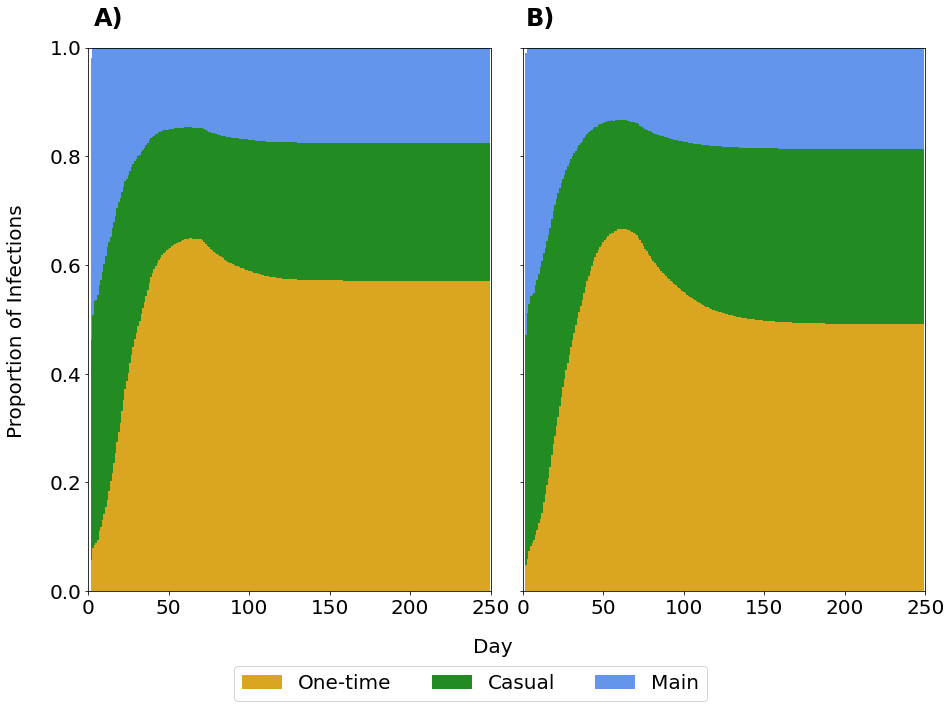

In [6]:
p_ot_mean = np.mean(p_ot, axis = 0)
p_c_mean = np.mean(p_c, axis = 0)
p_m_mean = np.mean(p_m, axis = 0)

p_ot_mean2 = np.mean(p_ot2, axis = 0)
p_c_mean2 = np.mean(p_c2, axis = 0)
p_m_mean2 = np.mean(p_m2, axis = 0)



fig = plt.figure(figsize = (15,10))
gs = fig.add_gridspec(1, 2, hspace=0.4, wspace=0.08)
(ax1, ax2) = gs.subplots(sharex='col', sharey=True)
x = np.arange(250)

fig.text(0.5, 0.04, 'Day', ha='center')
fig.text(0.05, 0.5, 'Proportion of Infections', va='center', rotation='vertical')

# Plot array1 at the bottom
ax1.bar(x, p_ot_mean, color = "goldenrod", label = "One-time", width = 1)
ax1.bar(x, p_c_mean, bottom=p_ot_mean, color = "forestgreen", label = "Casual", width = 1)
ax1.bar(x, p_m_mean, bottom=p_ot_mean + p_c_mean, color = "cornflowerblue", label = "Main", width = 1)

ax2.bar(x, p_ot_mean2, color = "goldenrod", label = "One-time", width = 1)
ax2.bar(x, p_c_mean2, bottom=p_ot_mean2, color = "forestgreen", label = "Casual", width = 1)
ax2.bar(x, p_m_mean2, bottom=p_ot_mean2 + p_c_mean2, color = "cornflowerblue", label = "Main", width = 1)

ax1.set_xlim(0,250)
ax1.set_ylim(0,1)

ax2.set_xlim(0,250)
ax2.set_ylim(0,1)

fig.text(0.13, 0.92, 'A)', va='center', fontweight = 'bold', fontsize = 24)
fig.text(0.53, 0.92, 'B)', va='center', fontweight = 'bold', fontsize = 24)

# Step 3: Add labels and legend
plt.legend(loc='lower center', bbox_to_anchor=(-0.13, -0.22), ncol = 3)

plt.savefig('inf_source_bytype_beh2vax2.pdf', dpi=600, bbox_inches = "tight")#

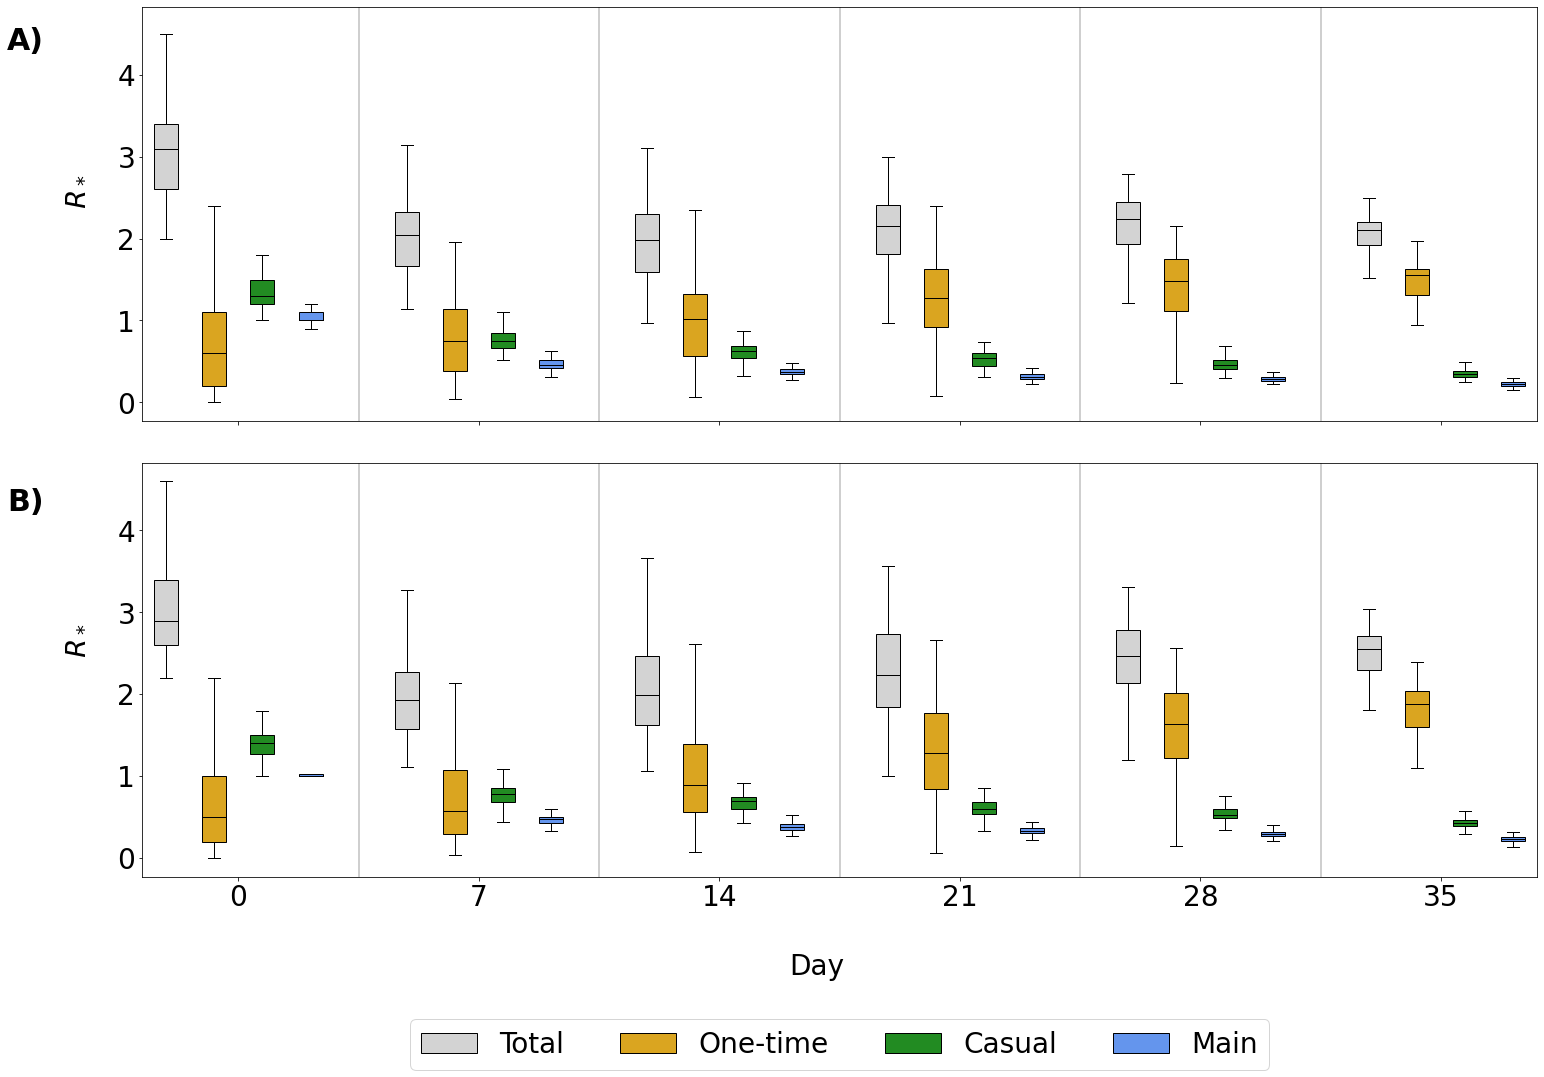

In [7]:
# Set all font sizes
SMALL_SIZE = 28
MEDIUM_SIZE = 30
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pos_tot = range(0, 29, 5)
pos_ot = range(1, 30, 5)
pos_c = range(2, 31, 5)
pos_m = range(3, 32, 5)

tot_dat = [r_tot[:,0], r_tot[:,1],  r_tot[:,2], r_tot[:,3],r_tot[:,4], r_tot[:,5]]
ot_dat = [r_ot[:,0], r_ot[:,1],  r_ot[:,2], r_ot[:,3],r_ot[:,4], r_ot[:,5]]
c_dat = [r_c[:,0], r_c[:,1],  r_c[:,2], r_c[:,3],r_c[:,4], r_c[:,5]]
m_dat = [r_m[:,0], r_m[:,1],  r_m[:,2], r_m[:,3],r_m[:,4], r_m[:,5]]

tot_dat2 = [r_tot2[:,0], r_tot2[:,1],  r_tot2[:,2], r_tot2[:,3],r_tot2[:,4], r_tot2[:,5]]
ot_dat2 = [r_ot2[:,0], r_ot2[:,1],  r_ot2[:,2], r_ot2[:,3],r_ot2[:,4], r_ot2[:,5]]
c_dat2 = [r_c2[:,0], r_c2[:,1],  r_c2[:,2], r_c2[:,3],r_c2[:,4], r_c2[:,5]]
m_dat2 = [r_m2[:,0], r_m2[:,1],  r_m2[:,2], r_m2[:,3],r_m2[:,4], r_m2[:,5]]


fig  = plt.figure(figsize = (25,16))
gs = fig.add_gridspec(2, 1, hspace=0.1, wspace=0.0)
(ax1, ax2) = gs.subplots( sharey=True, sharex=True)#sharex='row',

boxtot = ax1.boxplot(tot_dat, showfliers=False, positions = pos_tot, patch_artist=True)
boxot = ax1.boxplot(ot_dat, showfliers=False, positions = pos_ot, patch_artist=True)
boxc = ax1.boxplot(c_dat, showfliers=False, positions = pos_c, patch_artist=True)
boxm = ax1.boxplot(m_dat, showfliers=False, positions = pos_m, patch_artist=True)

# Apply the fill color to each dataset
for patch in boxtot['boxes']:
    patch.set_facecolor('lightgray')
    
for patch in boxot['boxes']:
    patch.set_facecolor('goldenrod')
    
for patch in boxc['boxes']:
    patch.set_facecolor('forestgreen')
    
for patch in boxm['boxes']:
    patch.set_facecolor('cornflowerblue')
    
for median in boxtot['medians']:
    median.set_color('black')
    
for median in boxot['medians']:
    median.set_color('black')
    
for median in boxc['medians']:
    median.set_color('black')
    
for median in boxm['medians']:
    median.set_color('black')
       
    
boxtot = ax2.boxplot(tot_dat2, showfliers=False, positions = pos_tot, patch_artist=True)
boxot = ax2.boxplot(ot_dat2, showfliers=False, positions = pos_ot, patch_artist=True)
boxc = ax2.boxplot(c_dat2, showfliers=False, positions = pos_c, patch_artist=True)
boxm = ax2.boxplot(m_dat2, showfliers=False, positions = pos_m, patch_artist=True)

# Apply the fill color to each dataset
for patch in boxtot['boxes']:
    patch.set_facecolor('lightgray')
    
for patch in boxot['boxes']:
    patch.set_facecolor('goldenrod')
    
for patch in boxc['boxes']:
    patch.set_facecolor('forestgreen')
    
for patch in boxm['boxes']:
    patch.set_facecolor('cornflowerblue')
    
for median in boxtot['medians']:
    median.set_color('black')
    
for median in boxot['medians']:
    median.set_color('black')
    
for median in boxc['medians']:
    median.set_color('black')
    
for median in boxm['medians']:
    median.set_color('black')
    
group_midpoints = [(positions[0] + positions[-1]) / 2 for positions in zip(pos_tot, pos_ot, pos_c, pos_m)]
group_labels = ['0', '7', '14', '21', '28', '35']  # Labels for each group

place_lines = [4, 9, 14, 19, 24]
for i in range(len(place_lines)):
    ax1.axvline(x = place_lines[i], color = "gray", alpha = 0.5)
    ax2.axvline(x = place_lines[i], color = "gray", alpha = 0.5)

ax2.set_xticks(group_midpoints)     # Set x-ticks to the midpoints of each group
ax2.set_xticklabels(group_labels)

fig.text(0.5, 0.04, 'Day', ha='center')
fig.text(0.08, 0.33, '$R_*$', va='center', rotation='vertical')
fig.text(0.08, 0.72, '$R_*$', va='center', rotation='vertical')

fig.text(0.05, 0.85, 'A)', va='center', fontweight = 'bold', fontsize = 30)
fig.text(0.05, 0.45, 'B)', va='center', fontweight = 'bold', fontsize = 30)

plt.legend([boxtot["boxes"][0], boxot["boxes"][0], boxc["boxes"][0], boxm["boxes"][0]], 
          ['Total', 'One-time', "Casual", "Main"], loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol = 4) 

plt.savefig('Rstar_boxplot_both.pdf', dpi=600, bbox_inches = "tight")

In [8]:
# Get values shown in boxplots
def calculate_summary_statistics(df):
    summary_stats = []
    for col in range(6):
        q25 = np.percentile(df[:,col], 25)
        q50 = np.percentile(df[:,col], 50)
        q75 = np.percentile(df[:,col], 75)
        summary_stats.append(f"{q50:.2f} ({q25:.2f}, {q75:.2f})")
    return summary_stats

# Create an empty DataFrame for the summary table
summary_table = pd.DataFrame(columns=[f"Day {i}; Median (P25, P75)" for i in [0,7,14,21,28,35]])

# Calculate the summary statistics for each dataset and add them as rows in the summary table
for i, dataset in enumerate([r_tot, r_ot, r_c, r_m, r_tot2, r_ot2, r_c2, r_m2]):
    summary_stats = calculate_summary_statistics(dataset)
    name_list = ["Total", "One-time", "Casual", "Main", "Total 2", "One-time 2", "Casual 2", "Main 2"]
    name = name_list[i]
    summary_table.loc[name] = summary_stats
    
print(summary_table)

           Day 0; Median (P25, P75) Day 7; Median (P25, P75)  \
Total             3.10 (2.60, 3.40)        2.04 (1.66, 2.33)   
One-time          0.60 (0.20, 1.10)        0.75 (0.39, 1.14)   
Casual            1.30 (1.20, 1.50)        0.75 (0.67, 0.85)   
Main              1.00 (1.00, 1.10)        0.45 (0.42, 0.52)   
Total 2           2.90 (2.60, 3.40)        1.93 (1.58, 2.27)   
One-time 2        0.50 (0.20, 1.00)        0.58 (0.29, 1.07)   
Casual 2          1.40 (1.27, 1.50)        0.78 (0.68, 0.86)   
Main 2            1.00 (1.00, 1.02)        0.48 (0.43, 0.50)   

           Day 14; Median (P25, P75) Day 21; Median (P25, P75)  \
Total              1.99 (1.60, 2.30)         2.16 (1.81, 2.41)   
One-time           1.01 (0.56, 1.33)         1.27 (0.92, 1.63)   
Casual             0.62 (0.54, 0.69)         0.54 (0.44, 0.61)   
Main               0.37 (0.34, 0.40)         0.31 (0.29, 0.35)   
Total 2            1.99 (1.62, 2.47)         2.23 (1.84, 2.74)   
One-time 2         0.89 (0.